# Capstone 3: *Cancer Gene Expression Classification*
## *Data Wrangling and EDA*
***


## 1.1 Table of Contents<a id='1.1_Contents'></a>
* [1 Data Wrangling and EDA](#1_Data_wrangling)
  * [1.1 Table of Contents](#1.1_Contents)
  * [1.2 Introduction](#1.2_Introduction)
  * [1.3 Data Dictionary](#1.3_Data_Dictionary)
  * [1.4 Importing the Dependencies](#1.4_Importing_the_Dependencies)
  * [1.5 Importing the Data](#1.5_Importing_the_Data)
  * [1.6 Missing Data](#1.6_Missing_Data)
  * [1.7 Dimensions](#1.7_Dimensions)
  * [1.8 Variance](#1.8_Variance)
  * [1.9 Collinearity](#1.9_Collinearity)
  * [1.10 Balance](#1.10_Balance)
  * [1.11 Summary](#1.11_Summary)

## 1.2 Introduction
<a id='1.2_Introduction'></a>

Classifying cancer type using gene expression profiling can help providers diagnose tumors quickly and with accuracy.  However, developing a meaningly machine machine learning method is difficult becasue of the curse of dimensionality.  The available dataframes are regularly wide and short because of the vast number of genes and the relatively small number of samples.  The dataframe I'll use in this project is no different.  

The [gene expression cancer RNA_Seq database](https://archive-beta.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq) is part of the larger RNA_Seq (HiSeq) PANCAN data set.  (PANCAN is the Pacreatic Cancer Action Network).  The database consists of samples representing 5 different cancer types.  This project seeks to find a model which will accurately classify samples in all five classes.

## 1.3 Data Dictionary
<a id='1.3_Data_Dictionary'></a>

| Abbreviation | Cancer Type|
|:---------|:-------------|
|BRCA|Breast|
|COAD|Colon|
|KIRC|Kidney|
|LUAD|Lung|
|PRAD|Prostate|


## 1.4 Importing the Dependencies
<a id='1.4_Importing_the_Dependencies'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from numpy import where

pd.set_option('display.max_rows', 70)

## 1.5 Importing the Data
<a id='1.5_Importing_the_Data'></a>

In [2]:
data = pd.read_csv("../source_data/data.csv")
labels = pd.read_csv("../source_data/labels.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  801 non-null    object
 1   Class       801 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


In [5]:
data.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [6]:
labels.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


## 1.6 Missing Data
<a id='1.6_Missing_Data'></a>

In [7]:
missing = pd.concat([data.isnull().sum(), 100 * data.isnull().mean()], axis=1)
missing.columns=['count', 'percent']
temp = missing.sort_values(by='percent', ascending=False)
if temp.percent[0] ==0:
    print ('There are no missing values in the dataframe')
else:
    print (temp)

There are no missing values in the dataframe


## 1.7 Dimensions
<a id='1.7_Dimensions'></a>

In [8]:
print ("There are", len(data.columns), "columns in the dataframe")

There are 20532 columns in the dataframe


The dataframe is very wide. With so many columns in the dataframe, feature selection and/or dimensional reduction will be a must.

## 1.8 Variance
<a id='1.8_Variance'></a>
One of the ways to reduce a wide dataframe is by feature selection.  We can evaluate a feature's influence on the target in part by looking at that feature's variance over all of the samples.  (Variance is the average squared deviation of the elements from the average value.)  If a feature has no change at all ro even very little change, then it might not be very useful in predicting the value of the taget.

First, I'll check the max and min values for the feature columns cumulatively.

In [9]:
max_list = []
min_list = []

for i in data:    
    if i == 'Unnamed: 0':
        continue
    else:
        max_list.append(data[i].max())
        min_list.append(data[i].min())
print('Maximum value out of all genes:', max(max_list))
print('Minimum value out of all genes:', min(min_list))

Maximum value out of all genes: 20.7788287118
Minimum value out of all genes: 0.0


Now, I'll check the variance of each feature column singularly.

In [10]:
# variance: average squared deviation of the elements from the average value

data_var = data.var(numeric_only=True).sort_values(ascending=True)

count = 0

for i in data_var:  
    if i==0:
        count += 1
print('Number of columns whose values have zero variance:', count)

Number of columns whose values have zero variance: 267


I will confirm the findings above by looking at the difference between the maximum and minimum values in each column.

In [11]:
# confirm variance findings by finding where max-min = 0 in df_max_min

df_max = pd.DataFrame(max_list)
df_max.columns = ["max"]

df_min = pd.DataFrame(min_list)
df_min.columns = ["min"]

df_max_min = pd.concat([df_max, df_min], axis=1)

df_max_min['max-min'] = (df_max_min['max']-df_max_min['min'])
#df_max_min['max-min'] = df_max_min.sort_values(by='max-min')

count = 0

for i in df_max_min['max-min']:  
    if i==0:
        count += 1
print('Number of columns whose max value minus min value equals zero:', count)

Number of columns whose max value minus min value equals zero: 267


The numbers above match the zero-variance findings, so we can confirm there are 267 columns which have no value change for any of the samples.

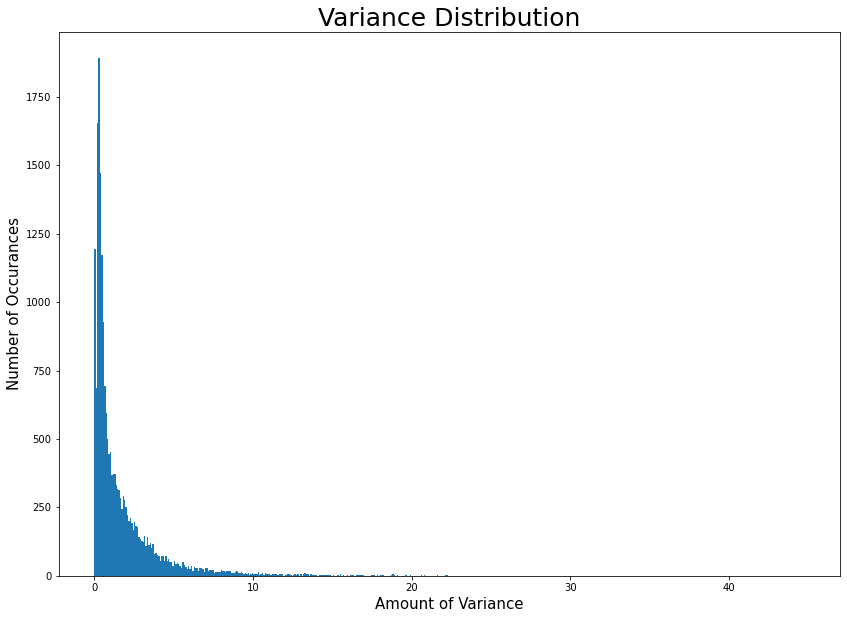

In [12]:
# plot the variance

plt.figure(figsize=(14,10))
plt.hist(data_var, bins=500)
plt.title("Variance Distribution", fontsize=25)
plt.ylabel('Number of Occurances', fontsize=15)
plt.xlabel('Amount of Variance', fontsize=15)
plt.show;



## 1.9 Collinearity
<a id='1.9_Collinearity'></a>
Another option for feature selection is to look for columns with high colinearity.  (Collinearity is the measure of linear relationship between features.)  If two features have high colinearity, they cannot independently predict the value of the target.  So, one of the pair might be removed.

I am choosing a correlation coefficient value of 90% or above.

In [13]:
#import time
#start_time = time.time()

data_corr = data.corr(method='pearson')
#data_corr

#end_time = time.time()
#elapsed_time = end_time - start_time
#print("Time to run cell:", elapsed_time, "seconds")


In [14]:
data_corr_high = data_corr[data_corr >= 0.9]
data_corr_high = data_corr_high.fillna(0)
data_corr_high = data_corr_high * 100
data_corr_high.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
gene_0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gene_1,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gene_2,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gene_3,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gene_4,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
def get_corr_for_one_gene (gene):
    #create a dataframe containing three columns:
    #  1.  The name of the gene 
    #  2.  The name of the gene with which it is highly collinear (>90%)
    #  3.  The correlation coefficient
    
    gene_df = pd.DataFrame()

    gene_data = data_corr_high[gene][data_corr_high[gene]!=0]

    gene_df['corr_coef %'] = gene_data
    gene_df = gene_df.reset_index()
    gene_df.rename(columns={'index': 'gene_B'}, inplace=True)
    gene_df['gene_A'] = gene
    gene_df = gene_df[gene_df['gene_A']!= gene_df['gene_B']]
    gene_df = gene_df[['gene_A','gene_B','corr_coef %']]
    return gene_df
    

In [16]:
# testing the function by asking for the high correlation coefficients for one gene

get_corr_for_one_gene ('gene_18')

,gene_A,gene_B,corr_coef %
1,gene_18,gene_219,90.582423
2,gene_18,gene_220,90.652721
3,gene_18,gene_450,90.150942


In [17]:
# creating a dataframe with the high correlation coefficients for all genes

all_gene_df = pd.DataFrame()

for i in data_corr_high:
    temp = get_corr_for_one_gene (i)
    all_gene_df = pd.concat([all_gene_df, temp])
    
all_gene_df.sort_values(by='corr_coef %', ascending=False)
    

,gene_A,gene_B,corr_coef %
0,gene_18918,gene_3527,100.000000
1,gene_3527,gene_18918,100.000000
1,gene_4375,gene_4376,100.000000
0,gene_4376,gene_4375,100.000000
1,gene_220,gene_219,99.313668
...,...,...,...
7,gene_3921,gene_18636,90.005134
2,gene_5759,gene_3356,90.003941
4,gene_3356,gene_5759,90.003941
3,gene_12739,gene_10714,90.002646


The dataframe created above contains duplicates for each pair with high collinearity. For example, (gene_202, gene_30 is the same as gene_30, gene_202). I will check the duplicates present in the dataframe for one gene and then I will recheck that same set after the removal of duplicate correlation pairs to verify they were removed successfully and without error.

In [18]:
# visualizing some duplicates to use for recheck later

print(all_gene_df[all_gene_df['gene_A']=='gene_4375'].sort_values(by='gene_B'))
print(all_gene_df[all_gene_df['gene_B']=='gene_4375'].sort_values(by='gene_A'))

      gene_A      gene_B  corr_coef %
2  gene_4375  gene_13979    94.760215
1  gene_4375   gene_4376   100.000000
       gene_A     gene_B  corr_coef %
0  gene_13979  gene_4375    94.760215
0   gene_4376  gene_4375   100.000000


In [19]:
# removing the duplicate pairs using frozenset

final_gene_df = all_gene_df[~all_gene_df[['gene_A', 'gene_B', 'corr_coef %']].apply(frozenset, axis=1).duplicated()]
final_gene_df.sort_values(by='corr_coef %', ascending=False)

,gene_A,gene_B,corr_coef %
1,gene_3527,gene_18918,100.000000
1,gene_4375,gene_4376,100.000000
2,gene_219,gene_220,99.313668
4,gene_4773,gene_8891,99.222581
11,gene_4773,gene_19313,99.192303
...,...,...,...
5,gene_6151,gene_11454,90.006620
3,gene_11608,gene_17135,90.006387
7,gene_3921,gene_18636,90.005134
4,gene_3356,gene_5759,90.003941


The number of rows was cut exactly in half which indicates all duplicate correlation pairs have been removed.  I will recheck the single gene from earlier.

In [20]:
# spot checking the removal of duplicates

print(final_gene_df[final_gene_df['gene_A']=='gene_4375'].sort_values(by='gene_B'))
print(final_gene_df[final_gene_df['gene_B']=='gene_4375'].sort_values(by='gene_A'))

      gene_A      gene_B  corr_coef %
2  gene_4375  gene_13979    94.760215
1  gene_4375   gene_4376   100.000000
Empty DataFrame
Columns: [gene_A, gene_B, corr_coef %]
Index: []


Duplicate correlation pairs have been successfully removed and all unique pairs have been retained.

We can see that there are numerous occurances of high collinearity in the dataframe, and there are even two pairs of genes whose correlation coefficient is 100%. If I decide to do feature selection, I could remove one gene from each pair.

In [21]:
# temp

final_gene_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2254 entries, 1 to 1
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gene_A       2254 non-null   object 
 1   gene_B       2254 non-null   object 
 2   corr_coef %  2254 non-null   float64
dtypes: float64(1), object(2)
memory usage: 70.4+ KB


I'd like to see which genes occur most frequently in the pairs with high correlation coefficients.  In other words, which genes have high colinearity with the largest number of other genes?  This might be another way to decide which genes to discard if performing feature selection.  It might also just be good information for the medical community and a source of future studies.

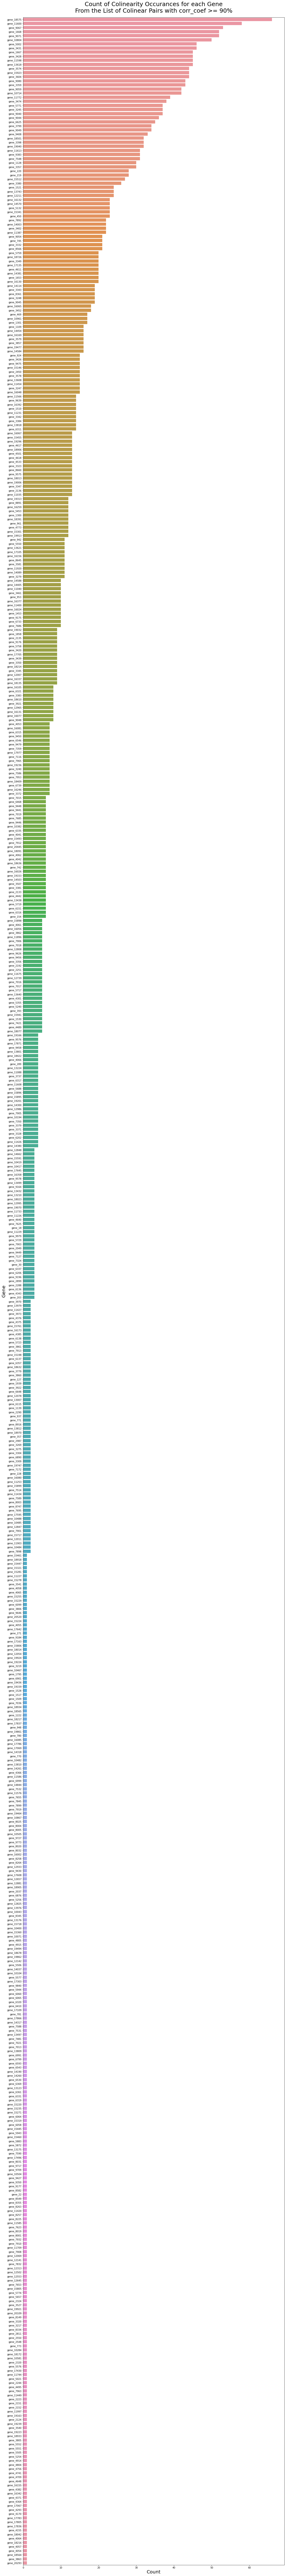

In [22]:
s1 = pd.Series(final_gene_df['gene_A'].copy())
s2 = pd.Series(final_gene_df['gene_B'].copy())
gene_corr_series = pd.concat([s1, s2])
gene_corr_df = pd.DataFrame(gene_corr_series)
gene_corr_df.columns =['gene']
gene_corr_df

fig, ax =plt.subplots(1,1,figsize=(20,200))
ax.set_title("Count of Colinearity Occurances for each Gene\nFrom the List of Colinear Pairs with corr_coef >= 90%", fontsize=25, pad=20)

sns.countplot(data = gene_corr_df, y='gene', order = gene_corr_df['gene'].value_counts().index)
plt.xlabel('Count',fontsize=20)
plt.ylabel('Gene',fontsize=20);

## 1.10 Balance
<a id='1.10_Balance'></a>
Another issue that often happens in datasets is imbalance.  If data is highly imbalanced we run the risk of a model predicting the majority class well while disregarding the minority class(es).  I will check to see if the distribution of data within the classes in this dataset is balanced or imbalanced.

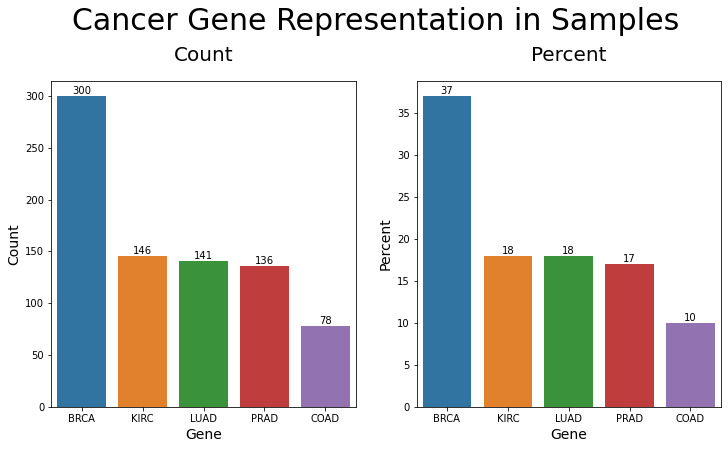

In [23]:
# counting the number in each class ans plotting the results

count = labels.groupby(by=["Class"]).count()
count = count.sort_values(by='Unnamed: 0', ascending=False)

percent = (count/801)*100
percent = percent.round(0)

fig, ax =plt.subplots(1,2,figsize=(12,6))
fig.suptitle("Cancer Gene Representation in Samples", fontsize=30, y=1.05)

sns.barplot(data=count, x=count.index, y='Unnamed: 0', ax=ax[0])
ax[0].set_title('Count', fontsize=20, pad=20)
ax[0].set_xlabel('Gene', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].bar_label(ax[0].containers[0])

sns.barplot(data=percent, x=percent.index, y='Unnamed: 0', ax=ax[1])
ax[1].set_title('Percent', fontsize=20, pad=20)
ax[1].set_xlabel('Gene', fontsize=14)
ax[1].set_ylabel('Percent', fontsize=14)
ax[1].bar_label(ax[1].containers[0]);

The classes are imbalanced although not severely so.  It might be good to try a model both with and without balancing the data to see which gives a more accurate result for all classes.

## 1.11 Summary
<a id='1.11_Summary'></a>

In this notebook I checked for missing values and found none.  I confirmed that the dataset is wide and short and explored variance and collinearity as potential components of feature selection.  Zero variance was found for 267 columns, so this could be a possible way to reduce the number of columns.  I also found 2254 pairs of columns with correlation coefficients over 90% and two pairs with 100%.  So, removing one of each pair would be another way to reduce the quantity of features.  A third method might be to reduce the number of columns based on the quantity of genes with which a particular gene shares a high correlation coefficient.

In the next notebook, I will explore dimensional reduction through PCA and make decisions final decisions about feature selection and dimensional reduction.  I will then try models with the data in its current, imbalanced form, and then also with various methods of balancing to see which yields greater model performance.